Test out a custom trainer that takes class weights into account

In [1]:
import pandas as pd
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch

from transformers import TrainingArguments, Trainer

import evaluate


from sklearn.utils.class_weight import compute_class_weight

import hyperopt

from torch import nn
from transformers import Trainer


/home/losullivan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-06 10:24:52.685018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:24:52.685054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:24:52.688516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:24:53.273501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

In [3]:
# Senolytic dataset - labelled
antibiotics_df = pd.read_excel('Dataset_antibiotic_superbug.xlsx', skiprows=4, sheet_name='Training data') 
antibiotics_df

,SMILES,Name,Rep 1,Rep 2,Mean,Label,Total positives,Total negatives
0,C=CC(C1=CC(=O)C(OC)=CC1=O)c1ccc(O)cc1,4-METHOXY-4'-HYDROXY-DALBERGIONE,1.041500,1.124500,1.083000,0,112.0,7573.0
1,C=C1CC/C=C(/C)CC[C@@H]2[C@@H]1CC2(C)C.O,(-)E-CARYOPHYLLENE hydrate,0.846050,1.028200,0.937125,0,NaN,NaN
2,CCCCCCCCCCCCCCCC(=O)OCC(O)CO,1-MONOPALMITIN,1.089400,1.247000,1.168200,0,NaN,NaN
3,CC1(C)C(=O)[C@@H]2O[C@@H]2[C@@]2(C)C1C[C@@H](O...,"1,2alpha-EPOXYDEACETOXYDIHYDROGEDUNIN",1.168100,1.171700,1.169900,0,NaN,NaN
4,CC1(C)C2CC(=O)[C@]3(C)C(CC[C@@]4(C)[C@H](c5cco...,"1,3-DIDEACETYL-7-DEACETOXY-7-OXOKHIVORIN",1.195300,1.228100,1.211700,0,NaN,NaN
...,...,...,...,...,...,...,...,...
7679,C=CCN1C(C)=N[C@H]2C=C[C@H](NCCCO)[C@H]21,BRD-M85061937,0.987031,1.071989,1.029510,0,NaN,NaN
7680,CI.O=C(COc1ccc(Cl)cc1Cl)OC[C@H]1CCCN2CCCC[C@@H]12,BRD-M95218988,1.043885,0.848576,0.946230,0,NaN,NaN
7681,O=C(O)C(Cl)Cl.[NaH],BRD-M97302542,0.998363,1.137398,1.067881,0,NaN,NaN
7682,N#Cc1cc(F)cc(Oc2ccc(S(=O)(=O)C(F)F)c3c2CC(F)(F...,BRD-M99730827,0.997820,1.269089,1.133454,0,NaN,NaN


In [4]:
training_df = senolytics_df[['SMILES', 'Label']]
training_df

,SMILES,Label
0,C=CC(C1=CC(=O)C(OC)=CC1=O)c1ccc(O)cc1,0
1,C=C1CC/C=C(/C)CC[C@@H]2[C@@H]1CC2(C)C.O,0
2,CCCCCCCCCCCCCCCC(=O)OCC(O)CO,0
3,CC1(C)C(=O)[C@@H]2O[C@@H]2[C@@]2(C)C1C[C@@H](O...,0
4,CC1(C)C2CC(=O)[C@]3(C)C(CC[C@@]4(C)[C@H](c5cco...,0
...,...,...
7679,C=CCN1C(C)=N[C@H]2C=C[C@H](NCCCO)[C@H]21,0
7680,CI.O=C(COc1ccc(Cl)cc1Cl)OC[C@H]1CCCN2CCCC[C@@H]12,0
7681,O=C(O)C(Cl)Cl.[NaH],0
7682,N#Cc1cc(F)cc(Oc2ccc(S(=O)(=O)C(F)F)c3c2CC(F)(F...,0


In [4]:
# # Subset for testing new code

#training_df =  training_df.groupby('senolytic', group_keys=False).apply(lambda x: x.sample(frac=0.1))
#training_df



In [5]:
# Check sample is representative of the actual distribution
sum(training_df['Label'])/len(training_df)

0.014575741801145237

## Finetune
https://huggingface.co/docs/transformers/training

In [6]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config = AutoConfig.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2, problem_type = "single_label_classification")

print(f"Model size: {model.num_parameters()} parameters.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 3428210 parameters.


In [7]:
from sklearn.model_selection import train_test_split
X = training_df[['SMILES']]
y = training_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # the data should be shuffled


In [7]:
# Dataset set up

#smiles_train = X_train['SMILES'].astype(str).tolist()
#smiles_test = X_test['SMILES'].astype(str).tolist()


In [8]:
# # https://huggingface.co/transformers/v3.2.0/custom_datasets.html -> does not work!!
# from transformers import AutoTokenizer, AutoModel
# import torch


# class SenolyticsDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         #print(idx)
#         input_ids = torch.tensor(self.encodings['input_ids'])
#         if self.labels is not None and idx in self.labels.keys():
#             target_ids = torch.tensor(self.labels[idx])
#         else:
#             # Handle the case where self.labels is None or idx is out of range
#             target_ids = None
#         return {"input_ids": input_ids, "labels": target_ids}

#     def __len__(self):
#         return len(self.labels)
# #train_dataset = IMDbDataset(train_encodings, train_labels)
# #val_dataset = IMDbDataset(val_encodings, val_labels)
# #test_dataset = IMDbDataset(test_encodings, test_labels)

# tokenized_train = tokenizer(smiles_train, padding=True, truncation=True, max_length=None, return_tensors='pt')
# tokenized_test = tokenizer(smiles_test, padding=True, truncation=True, max_length=None, return_tensors='pt')

# train_dataset = SenolyticsDataset(tokenized_train, y_train)
# test_dataset = SenolyticsDataset(tokenized_test, y_test)


In [8]:
import torch

#Current version
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, labels, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

        # Store the labels
        self.labels = labels.tolist()

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)


In [9]:
train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)

In [10]:
type(train_dataset[-1]['input_ids'])

torch.Tensor

In [11]:


metric = evaluate.load("f1")

In [12]:
# https://stackoverflow.com/questions/67457480/how-to-get-the-accuracy-per-epoch-or-step-for-the-huggingface-transformers-train

def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [13]:
# Class weights




class_weights = compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)


print(class_weights)

[ 0.50735849 34.47435897]


In [14]:
# https://huggingface.co/docs/transformers/main/main_classes/trainer




class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss with class_weights=balanced from above
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device, dtype=torch.float))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [16]:
X = training_df[['SMILES']]
y = training_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)


In [17]:
# Code crashes no idea why, I have copied this from the terminal
best_params =  {'learning_rate': 9.522117281262688e-05, 'weight_decay': 0.020220816653914182, 'num_train_epochs': 9}
print(best_params)

#f = open("best_trial_100.txt", "r")
#print(f.read())

{'learning_rate': 9.522117281262688e-05, 'weight_decay': 0.020220816653914182, 'num_train_epochs': 9}


In [18]:
#import json

# Load the dictionary from the text file
#with open("best_trial_100.txt", "r") as fp:
#    best_trial_dict = json.load(fp)

#print(best_trial_dict['best_params'])
#best_params = best_trial_dict['best_params']

In [19]:
from transformers import TrainingArguments, Trainer

# many more parameters to experiment with https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_antibiotics", load_best_model_at_end=True, evaluation_strategy='epoch',
    logging_strategy="epoch", save_strategy="epoch",per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,optim="adamw_torch", num_train_epochs=best_params['num_train_epochs'], learning_rate=best_params['learning_rate'],
                                  weight_decay=best_params['weight_decay']) # switch optimizer to avoid warning)


In [20]:
from transformers import TrainerCallback
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Define a callback for printing validation loss
class PrintValidationLossCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        if state is not None and hasattr(state, 'eval_loss'):
            print(f"Validation loss: {state.eval_loss:.4f}")

# Add the callback to the trainer
trainer.add_callback(PrintValidationLossCallback())
#trainer.train()

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.583600,1.367716,0.987858,0.176471,1.000000,0.300000
2,0.455300,1.284592,0.986123,0.323529,0.550000,0.407407
3,0.367700,1.366471,0.987424,0.323529,0.647059,0.431373
4,0.314400,1.128973,0.985256,0.352941,0.500000,0.413793
5,0.245300,1.379254,0.987424,0.352941,0.631579,0.452830
6,0.199700,1.285699,0.984389,0.352941,0.461538,0.400000
7,0.162500,1.494077,0.986557,0.352941,0.571429,0.436364
8,0.144800,1.541400,0.986557,0.352941,0.571429,0.436364
9,0.134800,1.510317,0.985690,0.352941,0.521739,0.421053


TrainOutput(global_step=3033, training_loss=0.28979223033126494, metrics={'train_runtime': 112.3684, 'train_samples_per_second': 430.744, 'train_steps_per_second': 26.992, 'total_flos': 212557916583648.0, 'train_loss': 0.28979223033126494, 'epoch': 9.0})

In [22]:
# Save the model
trainer.save_model("./antibiotics_training_set_1")

In [23]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [24]:
predictions = trainer.predict(test_dataset)

In [25]:
predictions.predictions

array([[ 5.1336436, -5.2346034],
       [-3.3564415,  3.3990428],
       [ 3.5829117, -3.6187983],
       ...,
       [ 3.6712527, -3.691464 ],
       [ 4.022172 , -4.091191 ],
       [ 5.8757386, -6.007861 ]], dtype=float32)

In [26]:
y_pred = np.argmax(predictions.predictions, axis=-1)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [27]:
trainer.evaluate()

{'eval_loss': 1.1289728879928589,
 'eval_accuracy': 0.9852558542931483,
 'eval_recall': 0.35294117647058826,
 'eval_precision': 0.5,
 'eval_f1': 0.41379310344827586,
 'eval_runtime': 4.6286,
 'eval_samples_per_second': 498.202,
 'eval_steps_per_second': 7.994,
 'epoch': 9.0}

In [28]:
y_test.sum()

34

In [29]:
# senolytics predicted
y_pred.sum()

24

In [30]:
trainer.state.log_history



[{'loss': 0.5836,
  'learning_rate': 8.464104250011278e-05,
  'epoch': 1.0,
  'step': 337},
 {'eval_loss': 1.3677161931991577,
  'eval_accuracy': 0.9878577623590633,
  'eval_recall': 0.17647058823529413,
  'eval_precision': 1.0,
  'eval_f1': 0.3,
  'eval_runtime': 5.4572,
  'eval_samples_per_second': 422.558,
  'eval_steps_per_second': 6.78,
  'epoch': 1.0,
  'step': 337},
 {'loss': 0.4553,
  'learning_rate': 7.406091218759868e-05,
  'epoch': 2.0,
  'step': 674},
 {'eval_loss': 1.2845922708511353,
  'eval_accuracy': 0.9861231569817867,
  'eval_recall': 0.3235294117647059,
  'eval_precision': 0.55,
  'eval_f1': 0.4074074074074075,
  'eval_runtime': 4.7434,
  'eval_samples_per_second': 486.153,
  'eval_steps_per_second': 7.8,
  'epoch': 2.0,
  'step': 674},
 {'loss': 0.3677,
  'learning_rate': 6.348078187508458e-05,
  'epoch': 3.0,
  'step': 1011},
 {'eval_loss': 1.3664705753326416,
  'eval_accuracy': 0.9874241110147441,
  'eval_recall': 0.3235294117647059,
  'eval_precision': 0.64705882

In [31]:
training_losses = [element['loss'] for element in trainer.state.log_history if 'loss' in element.keys()]
val_losses = [element['eval_loss'] for element in trainer.state.log_history if 'eval_loss' in element.keys()]

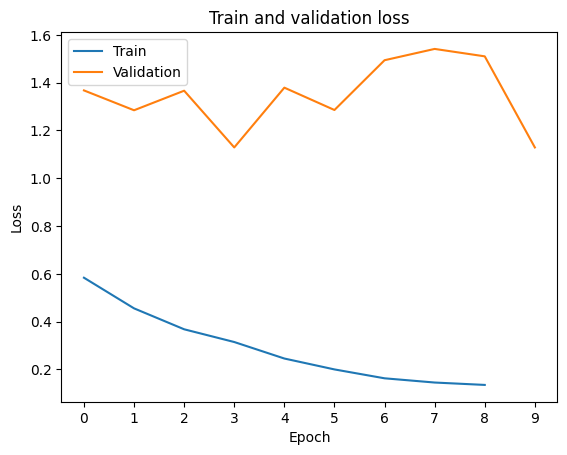

In [32]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.title("Train and validation loss")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.xticks([i for i in range(0,len(val_losses))])
plt.legend(['Train', 'Validation'])
plt.show()

Accuracy: 0.9852558542931483
Precision: 0.5
Recall: 0.35294117647058826
F1: 0.41379310344827586




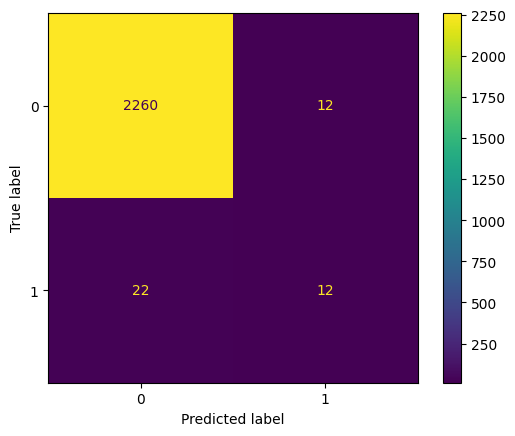

In [33]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


print("\n")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)


disp.plot()

plt.show()




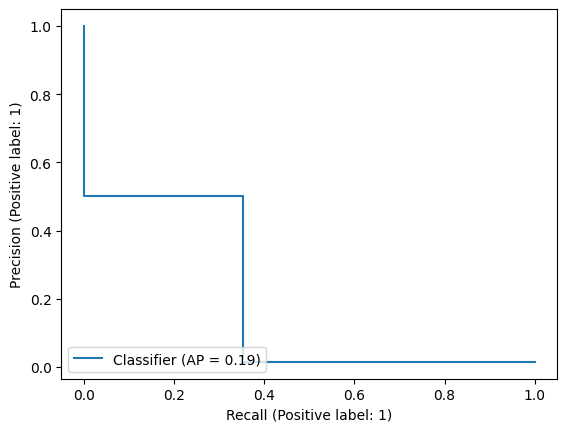

In [34]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()



In [35]:
# https://stackoverflow.com/questions/67432457/python-get-the-index-of-two-list-where-the-values-are-the-same
print([i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1])

[85, 277, 444, 505, 575, 690, 826, 939, 1121, 1514, 1576, 1776]


In [46]:
#X_test.iloc[213]

In [36]:
#where they equal
correct_predictions_indices = [i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1]

for prediction_index in correct_predictions_indices:
    print(X_test.iloc[prediction_index])

SMILES    CN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ccc(F)c...
Name: 798, dtype: object
SMILES    CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...
Name: 2141, dtype: object
SMILES    CC1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F...
Name: 2040, dtype: object
SMILES    CC1(C)C(C(=O)O)N2C(=O)C[C@H]2S1(=O)=O
Name: 2061, dtype: object
SMILES    COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...
Name: 1527, dtype: object
SMILES    N[C@@H](C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cl)CS[...
Name: 495, dtype: object
SMILES    CO/N=C1\CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)...
Name: 2581, dtype: object
SMILES    CC1CCc2cc(F)cc3c(=O)c(C(=O)O)cn1c23
Name: 1033, dtype: object
SMILES    CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(C=...
Name: 1940, dtype: object
SMILES    CCCCCCCCCCCCCCCCCC(=O)O.CC[C@H]1OC(=O)[C@H](C)...
Name: 932, dtype: object
SMILES    O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O
Name: 602, dtype: object
SMILES    CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c2...
Name: 1363, dtype: object


In [37]:
#where they equal
correct_predictions_indices = [i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1]

for prediction_index in correct_predictions_indices:
    print(antibiotics_df.loc[X_test.iloc[[prediction_index]].index[0]]['Name'])

DIFLOXACIN HYDROCHLORIDE
TETRACYCLINE HYDROCHLORIDE
SPARFLOXACIN
SULBACTAM
MOXIFLOXACIN HYDROCHLORIDE
CEFACLOR
BRD-A40787240
FLUMEQUINE
RIFAMPIN
ERYTHROMYCIN STEARATE
CIPROFLOXACIN
LOMEFLOXACIN HYDROCHLORIDE
